### Accessing wavelength (micron), flux density (Jansky) in planetary nebulae spectra of ISO-SWS / Highly Processed Data Products (HPDP) by Greg Sloan et al.

In [3]:
dataDir = "/Users/ioannisa/Desktop/python/miri_devel/notebooks/ISOSWS_PlanetaryNebulae/PNe_data/"
import funcs
import numpy as np
from astropy.io import fits
import scipy.interpolate as scp_interpolate
import matplotlib.pyplot as plt
%matplotlib notebook


<IPython.core.display.Javascript object>


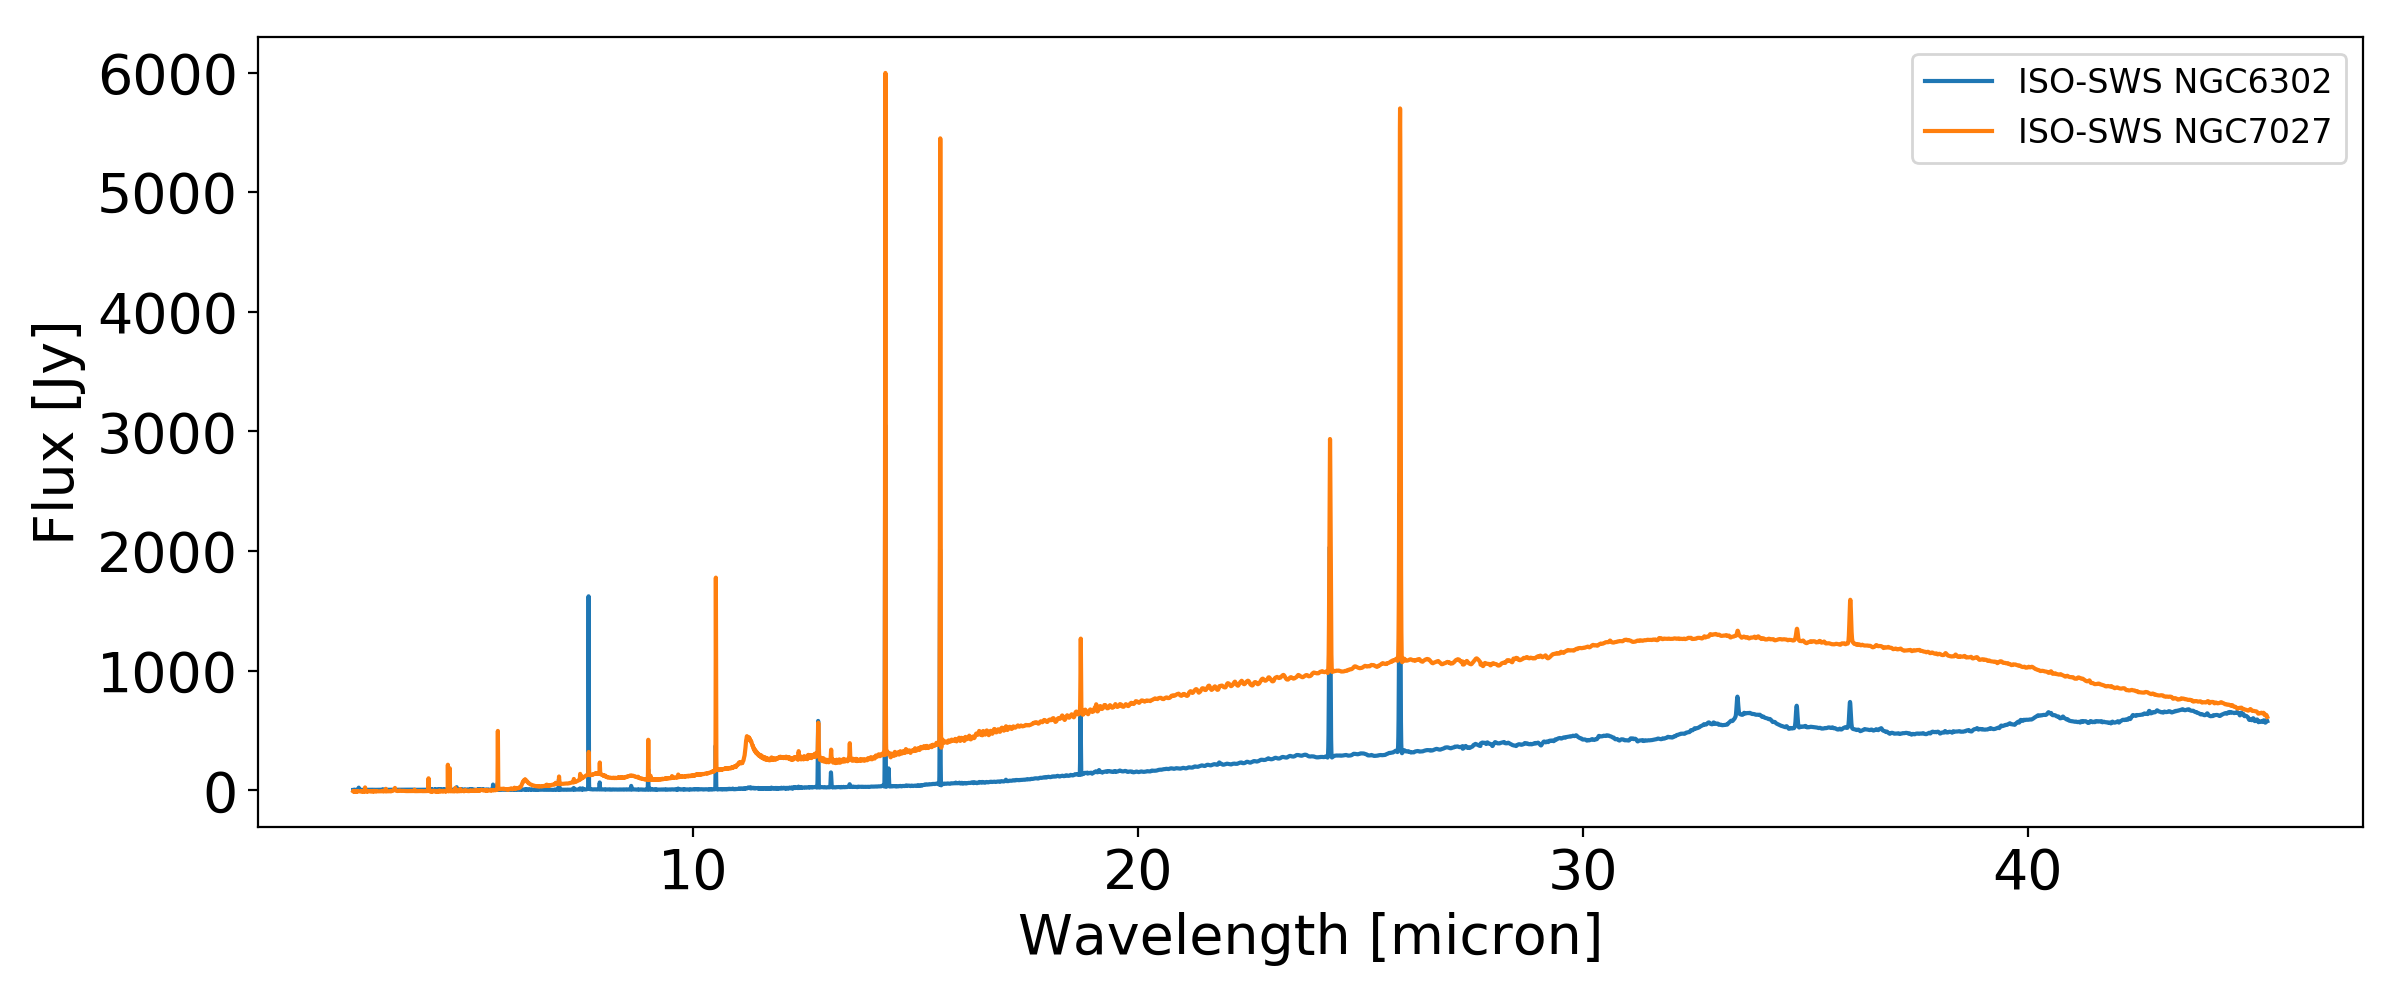

In [4]:
hdulist1 = fits.open(dataDir + "09400716_sws.fit")
hdulist2 = fits.open(dataDir + "55800537_sws.fit")
# hdulist3 = fits.open(dataDir + "02400714_pws.fit")

plt.figure(figsize=(12,5))
plt.plot(hdulist1[0].data[:,0], hdulist1[0].data[:,1],label="ISO-SWS NGC6302")
plt.plot(hdulist2[0].data[:,0], hdulist2[0].data[:,1],label="ISO-SWS NGC7027")
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Flux [Jy]',fontsize=20)
plt.legend(loc='upper right',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [5]:
# spectral energy distribution
spec_hdulist = fits.open(dataDir + "09400716_sws.fit")
wavl = spec_hdulist[0].data[:,0]
spec = spec_hdulist[0].data[:,1]

# spatial extent
img_hdulist = fits.open(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")
NGC6302_img = np.flipud(img_hdulist[0].data) # data flipped because of way that python handles image data (y-axis zero point is at the top left corner, rather than bottom left corner)
NGC6302_img[NGC6302_img<0] = 0

# WCS
RA = spec_hdulist[0].header["ATTRA"] # Right Ascension, deg
DEC = spec_hdulist[0].header["ATTDEC"] # Declination, deg
CRPIX1 = img_hdulist[0].header["CRPIX1"] # Ref pix of axis 1
CRVAL1 = img_hdulist[0].header["CRVAL1"] # Right Ascension at Ref pix in decimal degrees
CRPIX2 = img_hdulist[0].header["CRPIX2"] # Ref pix of axis 2
CRVAL2 = img_hdulist[0].header["CRVAL2"] # Declination at Ref pix in decimal degrees
PIXSIZ = 0.04 # [arcsec/pix] Pixel projected spatial size, WFC3/UVIS, found on http://www.stsci.edu/hst/wfc3/design/at_a_glance/

print 'ISO pointing (RA,DEC) = ({},{}) deg'.format(RA,DEC)
print 'Image size: {} pix'.format(np.transpose(NGC6302_img).shape)
print 'Axis 1 reference value: {} RA, at pixel {}'.format(CRVAL1,CRPIX1)
print 'Axis 2 reference value: {} DEC, at pixel {} \n'.format(CRVAL2,CRPIX2)

# RA_D,RA_M,RA_S = np.floor(RA), np.floor((RA*60)%60), (np.abs(RA)*3600)%60
# DEC_D,DEC_M,DEC_S = np.floor(DEC), np.floor((DEC*60)%60), (np.abs(DEC)*3600)%60

# RA  = (RA_D*3600. + RA_M*60. + RA_S)/3600.
# DEC = (DEC_D*3600. + DEC_M*60. + DEC_S)/3600.

# Convert degrees to arcseconnds
CRVAL1_arcsec = CRVAL1*3600.
CRVAL2_arcsec = CRVAL2*3600.

# Reconstruct spatial grid
CREF1 = CRVAL1_arcsec-(NGC6302_img.shape[1]-CRPIX1)*PIXSIZ # position zero
CREF2 = CRVAL2_arcsec-(NGC6302_img.shape[0]-CRPIX2)*PIXSIZ # position zero

xaxis  = np.linspace(CREF1/3600.,(CREF1+NGC6302_img.shape[1]*PIXSIZ)/3600.,NGC6302_img.shape[1])
yaxis = np.linspace(CREF2/3600.,(CREF2+NGC6302_img.shape[0]*PIXSIZ)/3600.,NGC6302_img.shape[0])

extent = [xaxis[-1],xaxis[0], yaxis[0], yaxis[-1]]
print 'FoV extent: {}'.format(extent)

# ISO SWS field of view (not in RA and DEC!!! The field of view in the ISO SWS handbook is defined in the dispersion and cross-dispersion directions)
# corner1 = (CRVAL1_D + CRVAL1_M/60. + (CRVAL1_S-7.)/3600.,DEC)
# corner2 = (CRVAL1_D + CRVAL1_M/60. + (CRVAL1_S+7.)/3600.,DEC)
# corner3 = (CRVAL1_D + CRVAL1_M/60. + (CRVAL1_S+7.)/3600.,CRVAL2_D + CRVAL2_M/60. + (CRVAL2_S+10.)/3600.)
# corner4 = (CRVAL1_D + CRVAL1_M/60. + (CRVAL1_S-7.)/3600.,CRVAL2_D + CRVAL2_M/60. + (CRVAL2_S+10.)/3600.)

# print corner1
# print corner2
# print corner3
# print corner4

ISO pointing (RA,DEC) = (258.43421,-37.10172) deg
Image size: (5600, 4200) pix
Axis 1 reference value: 258.4536 RA, at pixel 2800.0
Axis 2 reference value: -37.1147 DEC, at pixel 2100.0 

FoV extent: [258.4847111111111, 258.4224888888889, -37.138033333333325, -37.09136666666666]


In [7]:
# hdulist = fits.open(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")
# print hdulist[0].data.shape

In [8]:
from astropy.wcs import WCS

w = WCS(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")
hdulist = fits.open(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")

NAXIS1 = hdulist[0].data.shape[0]
NAXIS2 = hdulist[0].data.shape[1]
x = np.arange(NAXIS2)
y = np.arange(NAXIS1)
X, Y = np.meshgrid(x, y)
ra, dec = w.wcs_pix2world(X, Y, 0)

print ra[2000,2000],dec[2000,2000]
print w.wcs_pix2world(2000,2000, 1)

258.4619290307624 -37.120692833391345
[array(258.46193245), array(-37.12070831)]


In [9]:
# print ra[2000,2000],dec[2000,2000]
# print w.wcs_pix2world(2000,2000, 1)

In [15]:
def load_wcs_from_file(filename):
    from matplotlib import pyplot as plt
    from astropy.io import fits
    from astropy.wcs import wcs
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here
    pixcrd = np.array([[0, 0], [24, 38], [45, 98]], np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 0)
    print(world)
    
    # Convert the same coordinates back to pixel coordinates.
    pixcrd2 = w.wcs_world2pix(world, 1)
    print(pixcrd2)

#     # These should be the same as the original pixel coordinates, modulo
#     # some floating-point error.
#     assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

In [16]:
load_wcs_from_file(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")


[[258.46877928 -37.15164154]
 [258.46880896 -37.15114272]
 [258.46904877 -37.15046275]]
[[ 1.  1.]
 [25. 39.]
 [46. 99.]]


In [17]:
wcs

NameError: name 'wcs' is not defined

<IPython.core.display.Javascript object>


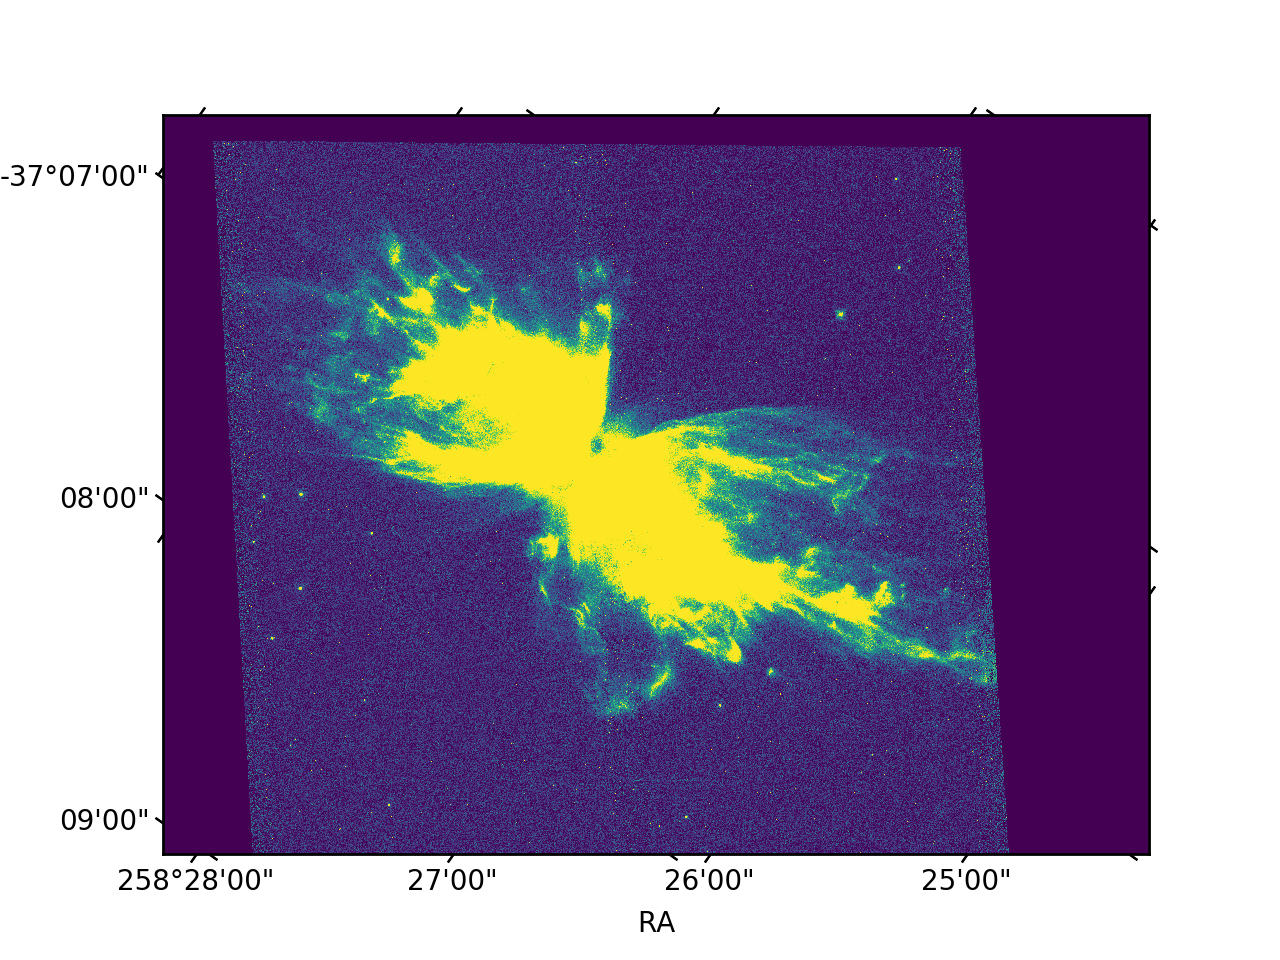

In [18]:
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

fig = plt.figure()
fig.add_subplot(111, projection=wcs)
plt.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis,vmin=0,vmax=0.01)
plt.xlabel('RA')
plt.ylabel('Dec')

In [19]:
img_hdulist[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 5600 / Axis length                                    
NAXIS2  =                 4200 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
OBJECT  = 'NGC 6302 in O II'   / Name of the object observed                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '17:16:41 (03/09/2009)' / Time of last modification                   
NEXTEND =                    0 / Number of standard extensions                  
DATE    = '2009-09-02T12:53:17' / date this file was written (yyyy-mm-dd)       
FILENAME= 'ngc6302_wfc3_f373n_drz_sci.fits' / name of file                      
FILETYPE= 'SCI      '       

<IPython.core.display.Javascript object>


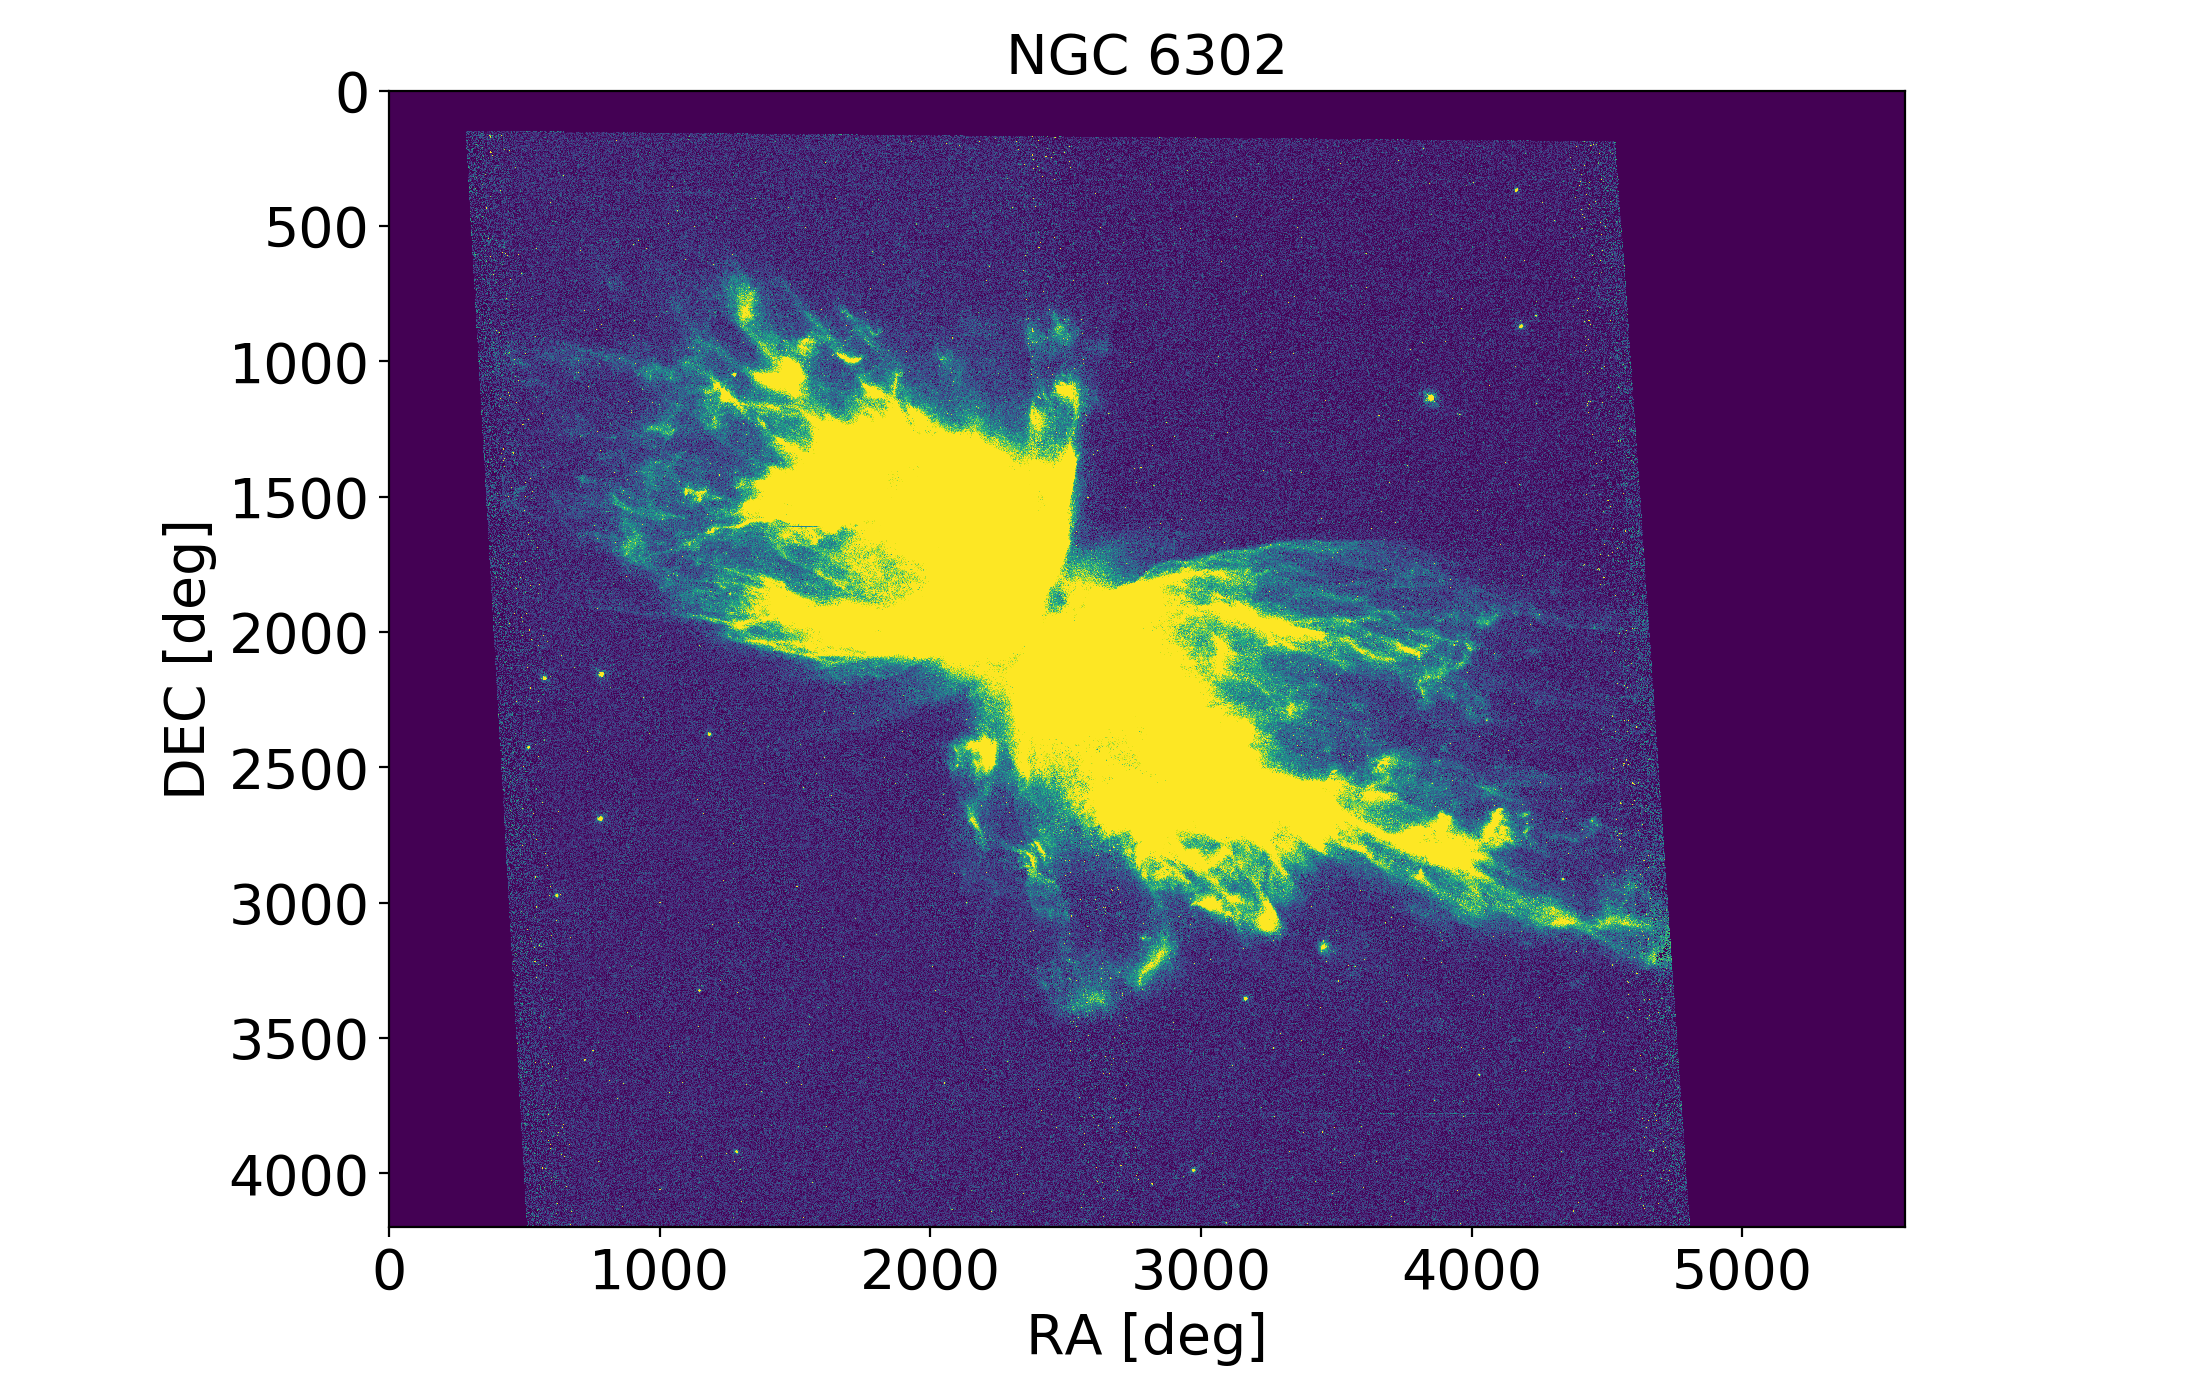

In [20]:
plt.figure(figsize=(11,7))
plt.imshow(NGC6302_img,vmin=0.,vmax=0.01)
# plt.scatter([RA],[DEC],c='r',s=40)
# plt.scatter([CRVAL1],[CRVAL2],marker='+',c='r',s=40)
# plt.scatter([corner1[0]],[corner1[1]],c='r',s=40)
# plt.scatter([corner2[0]],[corner2[1]],c='r',s=40)
# plt.scatter([corner3[0]],[corner3[1]],c='r',s=40)
# plt.scatter([corner4[0]],[corner4[1]],c='r',s=40)
plt.xlabel('RA [deg]',fontsize=20)
plt.ylabel('DEC [deg]',fontsize=20)
plt.title('NGC 6302',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [21]:
# x = 2800.
# y = 2100.
# ra = -9.101648897111537E-06*x + 6.373043167895588E-06*y
# dec = 6.373043167895588E-06*x + 9.101648897111537E-06*y

# print ra,dec

-0.0121012262593 0.036957983554


# Build MIRISim input cube from spatial and spectral information

In [9]:
# UNCOMMENT TO BUILD MIRISIM CUBES
# spectral energy distribution
spec_hdulist = fits.open(dataDir + "09400716_sws.fit")
wavl = spec_hdulist[0].data[:,0]
spec = spec_hdulist[0].data[:,1]

# spatial distribution NGC7027
img_hdulist = fits.open(dataDir + "hlsp_sm4ero_hst_wfc3_11504-ngc6302_f373n_v1_sci.fits")
pixel_scale = 0.04 # arcsec/pix, WFC3/UVIS
NGC6302_img = img_hdulist[0].data

#> normalise the image
image_total = np.sum(np.sum(NGC6302_img, axis=0), axis=0)
norm_image = NGC6302_img / image_total
image_dim = norm_image.shape

# create the datacubes
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    # give output filename
    out_filename = "mirisim_input_cube_band{}.fits".format(band)
    # spectral distribution, [microns] and [Jy]
    sel_wvl = (wavl>=funcs.mrs_aux('1A')[3][0]) & (wavl<=funcs.mrs_aux('1A')[3][1])
    wave_scale  = wavl[sel_wvl][1]-wavl[sel_wvl][0]
    interp_wavl = np.arange(wavl[sel_wvl][0]+wave_scale,wavl[sel_wvl][-1]-wave_scale,wave_scale)
    interp_spec = scp_interpolate.interp1d(wavl[sel_wvl],spec[sel_wvl])(interp_wavl)
    wave_length = len(interp_wavl)
    
    # create the datacube
    datacube = np.zeros([wave_length,image_dim[0],image_dim[1]])
    for n in range(wave_length):
        frame = ((interp_spec[n] * norm_image) * 1.e6) /pixel_scale**2 # convert Jansky to microJy per arcsec^2
        datacube[n,:,:] = frame
    
    prihdr = fits.Header()
    prihdr['CRVAL1'] = 0
    prihdr['CRPIX1'] = CRPIX1
    prihdr['CDELT1'] = pixel_scale
    prihdr['CTYPE1'] = 'RA---TAN'
    prihdr['CUNIT1'] = 'arcsecond'
    prihdr['CRVAL2'] = 0
    prihdr['CRPIX2'] = CRPIX2
    prihdr['CDELT2'] = pixel_scale
    prihdr['CTYPE2'] = 'DEC--TAN'
    prihdr['CUNIT2'] = 'arcsecond'
    prihdr['CRVAL3'] = interp_wavl[0]
    prihdr['CRPIX3'] = 0
    prihdr['CDELT3'] = wave_scale    
    prihdr['CTYPE3'] = 'WAVE'
    prihdr['CUNIT3'] = 'micron'
    prihdr['UNITS'] = 'uJy arcsec-2'
    
    # save fits
    out_hdu = fits.PrimaryHDU(datacube,header=prihdr)
    hdulist = fits.HDUList([out_hdu])
    hdulist.writeto(out_filename,overwrite=True)
    hdulist.close()

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
